In [124]:
import vof
from vof import forecaster
from vof import optimizer

In [2]:
#pip install altair

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import statsmodels.api as sm
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
import random
#from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from datetime import date
import nevergrad as ng
from joblib import Parallel, delayed

from darts.utils import timeseries_generation as tg
from darts import TimeSeries
from darts.metrics import rmse

#from darts.models import Theta, FFT, ExponentialSmoothing, Prophet, RegressionModel,NaiveSeasonal,LightGBMModel,RandomForest
import darts.models


plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

<AxesSubplot:xlabel='Time'>

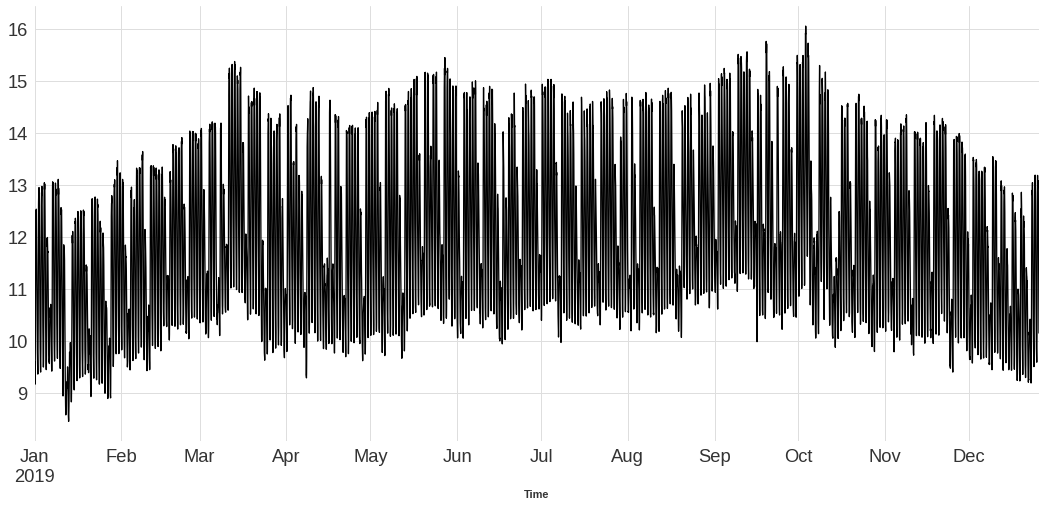

In [205]:
data = pd.read_csv("data/district/Actuals.csv", index_col=0, parse_dates=True).loc['2019-01-01':'2019-12-25']
data.head(5)
data.columns = ['y','Pressure_kpa','Cloud Cover (%)','Humidity (%)','Temperature (C)','Wind Direction (deg)','Wind Speed (kmh)']
data.y = data.y/100000

data.y.plot()

# Creating forecast from Fact data

## Estimating Lags and adding them to the object

In [206]:
def estimateSignificantLags(ts, nlags = 360, significantLags = 11): 
    pacf = sm.tsa.stattools.pacf(ts, nlags)
    lags = np.argsort(-np.abs(pacf))[1:significantLags+1]
    plt.plot(pacf,'*--')
    plt.plot(lags,pacf[lags],'o')
    return lags

[  1   2   3  23  24  26 168 169 336 337]


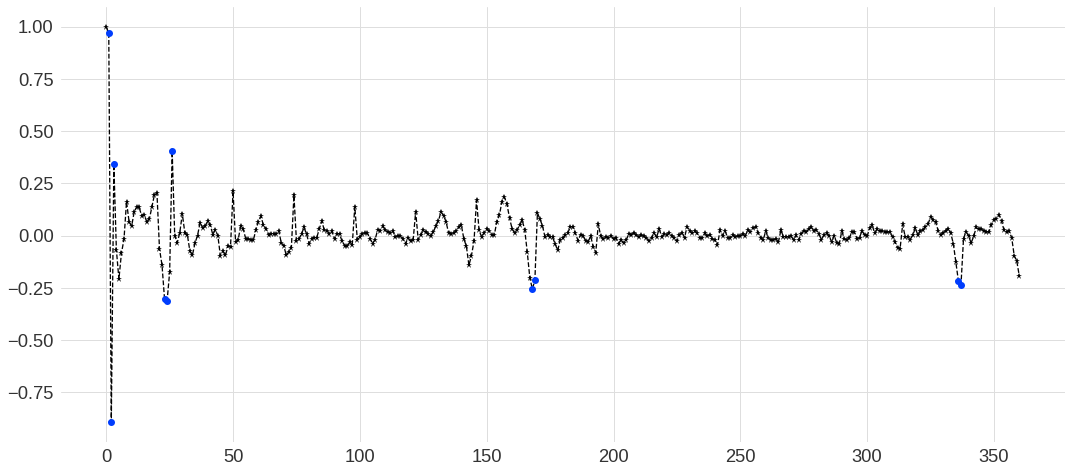

In [207]:
lags = estimateSignificantLags(data.y, significantLags = 10)
# add lags for certain days
lags = np.unique(np.hstack([lags]))
print(np.sort(lags))

## Now the dataset is ready, so we can start building a dataframe with different predictions for further optimization.
All predictions will be in the same dataframe optimization_df together with the Fact data.
We run several prediction models

In [208]:
input_timeseries = TimeSeries.from_dataframe(data, value_cols=['y'])#[0:-24]
future = TimeSeries.from_dataframe(data, value_cols=['Pressure_kpa', 'Cloud Cover (%)',
                                                     'Humidity (%)','Temperature (C)', 
                                                     'Wind Direction (deg)', 'Wind Speed (kmh)'])


In [209]:
# We first set aside the first 25% as training series:
input_train, _ = input_timeseries.split_before(0.5)

def eval_model(model, past_covariates=None, future_covariates=None, retrain = False):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=input_timeseries, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.5, 
                                          retrain=retrain,
                                          verbose=True, 
                                          forecast_horizon=24)
    
    input_timeseries[-len(backtest)-336:].plot()
    backtest.plot(label='backtest (n=10)')
    print('Backtest RMSE = {}'.format(rmse(input_timeseries, backtest)))


  0%|          | 0/4286 [00:00<?, ?it/s]

Backtest RMSE = 0.6569649807667535


  0%|          | 0/4286 [00:00<?, ?it/s]

Backtest RMSE = 1.044978949416127


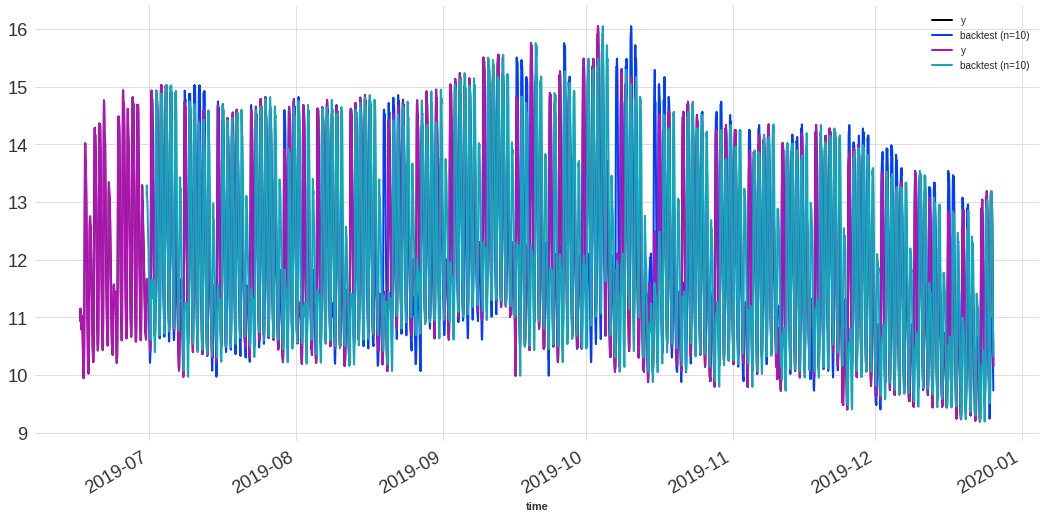

In [210]:
naive_model_weekly = NaiveSeasonal(K=168)
naive_model_weekly.fit(input_train)

eval_model(naive_model_weekly, retrain=True)

naive_model_daily = NaiveSeasonal(K=24)
naive_model_daily.fit(input_train)

eval_model(naive_model_daily, retrain=True)


  0%|          | 0/4286 [00:00<?, ?it/s]

Backtest RMSE = 0.6430614352703893


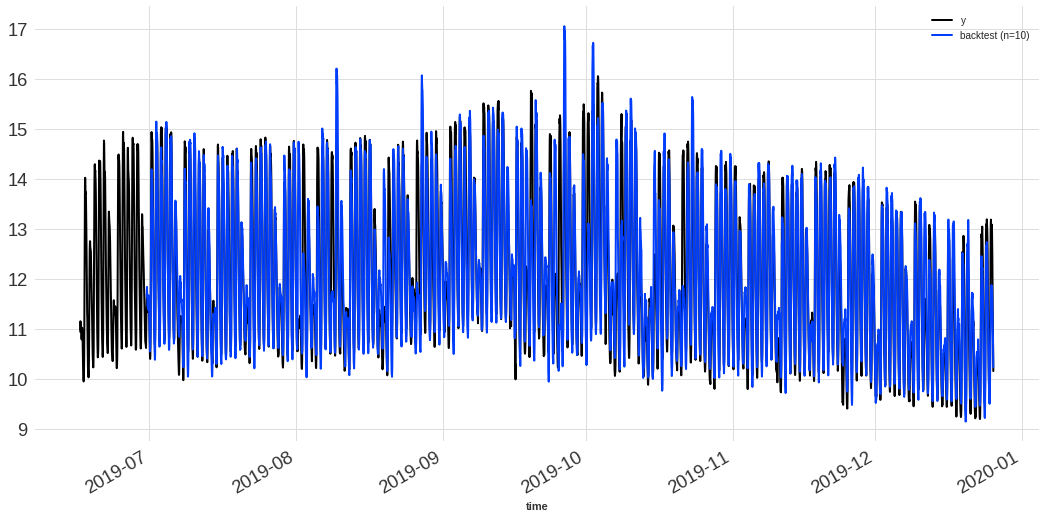

In [211]:
regr_model_lags =  RegressionModel(lags=[-1,   -2,   -3,   -5,  -23,  -24,  -26,  -50, -168, -169])

regr_model_lags.fit(input_train)

eval_model(regr_model_lags)

  0%|          | 0/4262 [00:00<?, ?it/s]

Backtest RMSE = 0.6479202785518625


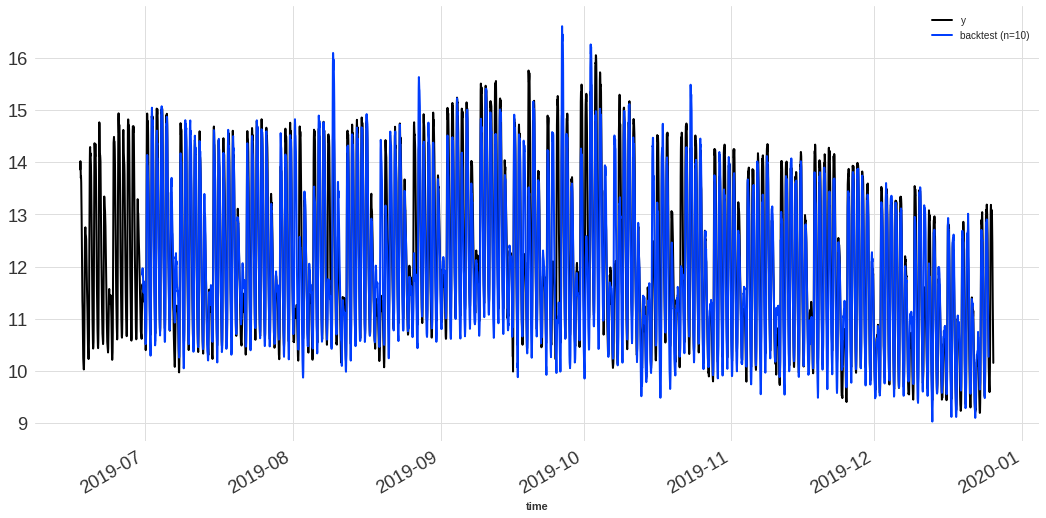

In [212]:
regr_model_cov = RegressionModel(lags=[-1,   -2,   -3,   -5,  -23,  -24,  -26,  -50, -168, -169],
                                 #lags_future_covariates=list(range(-6,72)))
                                 lags_future_covariates=[-25, -24, -23, -5, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

regr_model_cov.fit(input_train,
               future_covariates=future)

eval_model(regr_model_cov)


  0%|          | 0/4262 [00:00<?, ?it/s]

Backtest RMSE = 0.80727673086046


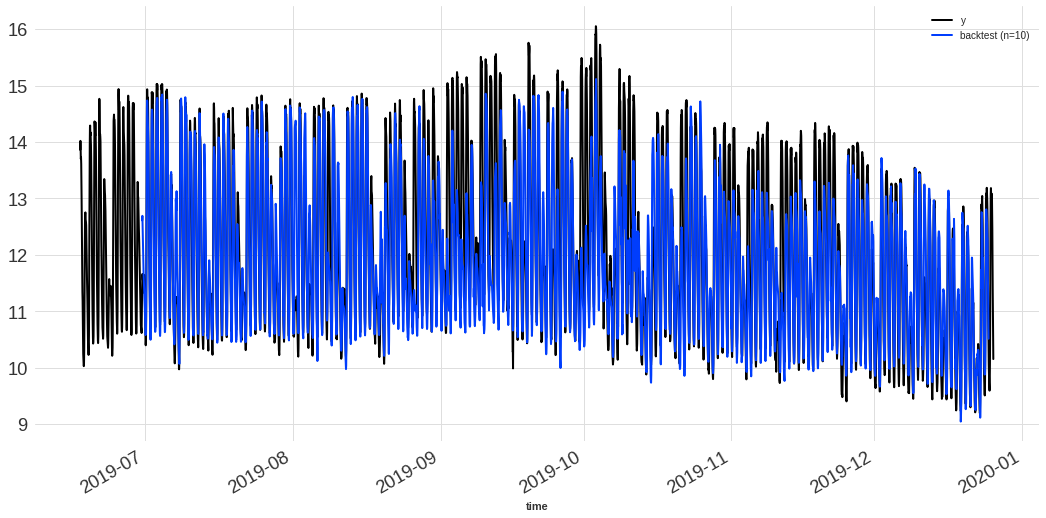

In [213]:
lgbm_model_cov = LightGBMModel(lags=[-1,   -2,   -3,   -5,  -23,  -24,  -26,  -50, -168, -169],
                              lags_future_covariates=[-25, -24, -23, -5, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
                              #lags_future_covariates=list(range(-6,72))
                              )

lgbm_model_cov.fit(input_train, future_covariates=future)

eval_model(lgbm_model_cov)


  0%|          | 0/4286 [00:00<?, ?it/s]

Backtest RMSE = 0.5835094552304254


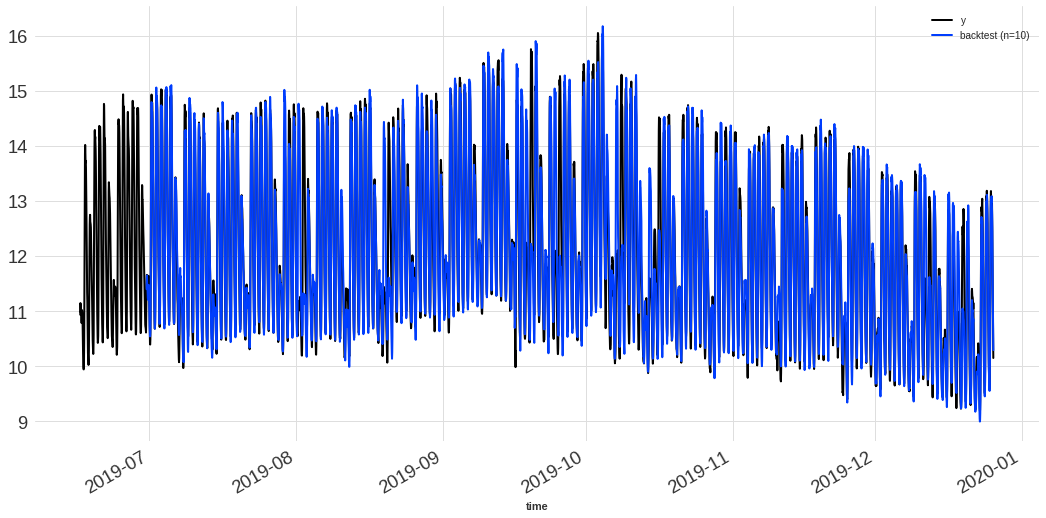

In [214]:
theta_model =  Theta(2, seasonality_period=168)

theta_model.fit(input_train)

eval_model(theta_model, retrain=True)


  0%|          | 0/4286 [00:00<?, ?it/s]

Backtest RMSE = 1.011442240136702


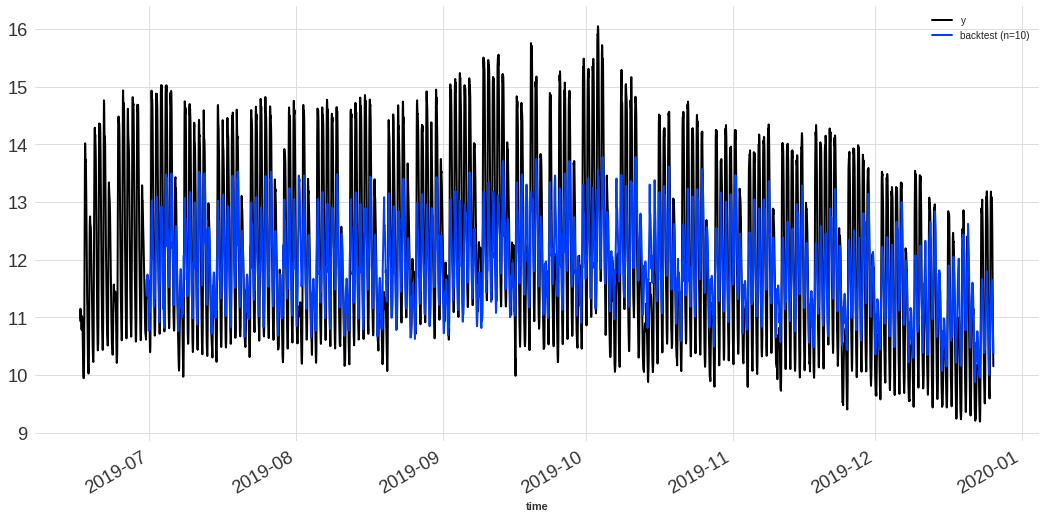

In [215]:
fft_model =  FFT(nr_freqs_to_keep=10, required_matches=set(), trend='poly', trend_poly_degree=2)

fft_model.fit(input_train)

eval_model(fft_model, retrain=True)


In [ ]:
exp_smooth_model =  ExponentialSmoothing(seasonal_periods=168)

exp_smooth_model.fit(input_train)

eval_model(exp_smooth_model, retrain=True)


In [ ]:
prophet_model =  Prophet(yearly_seasonality=True)

prophet_model.fit(input_train)

eval_model(prophet_model, retrain=True)


In [ ]:
def get_historical_forecasts(model,model_display_name, future_covs=False):

    if future_covs == False:
        #print(model_display_name, 'no future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                                    forecast_horizon=72, stride=24, verbose=True,
                                                    start=672, last_points_only=False, overlap_end=False)
    else:
        #print(model_display_name, 'with future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                                    forecast_horizon=72, stride=24, verbose=True,
                                                    future_covariates=future, overlap_end=False,
                                                    start=672, last_points_only=False)
        
    res_df = pd.DataFrame()

    for i in range(len(forecast)):
        pred_df = forecast[i].pd_dataframe()
        pred_df['prediction_date'] = forecast[i].get_timestamp_at_point(0)
        pred_df['model'] = model_display_name
        pred_df.reset_index(inplace=True)
        pred_df.columns = ['ts','value','prediction_date','model']
        res_df = res_df.append(pred_df)
    
    if future_covs == False:
        return res_df.iloc[:-72]
    else:
        return res_df


models = {'Naive weekly':[naive_model_weekly,False],
          'Naive daily': [naive_model_daily,False],
          'RegressionModelLags':[regr_model_lags,False],
          'RegressionModelCov':[regr_model_cov,True],
          'LGBM':[lgbm_model_cov,True],
          'Theta':[theta_model,False],
          'FFT':[fft_model,False],
          #'ExponentialSmoothing':[exp_smooth_model,False],
          #'Prophet':[prophet_model,False]
         }

optimization_df = pd.DataFrame()

import time




runtime_df = pd.DataFrame(index=models.keys(),columns=['runtime'])

for model in models.keys():
    print(model)
    start=time.time()
    optimization_df = optimization_df.append(get_historical_forecasts(model = models[model][0],
                                                                      model_display_name = model,
                                                                      future_covs = models[model][1]))
    end = time.time()
    runtime_df.loc[model,'runtime'] = (end-start)

Naive weekly


  0%|          | 0/329 [00:00<?, ?it/s]

Naive daily


  0%|          | 0/329 [00:00<?, ?it/s]

RegressionModelLags


  0%|          | 0/329 [00:00<?, ?it/s]

RegressionModelCov


  0%|          | 0/328 [00:00<?, ?it/s]

LGBM


  0%|          | 0/328 [00:00<?, ?it/s]

In [176]:
runtime_df

runtime
Naive weekly           0.920252
Naive daily            0.891298
RegressionModelLags   41.445379
RegressionModelCov    76.518243
LGBM                 111.762915
Theta                   2.64292
FFT                    1.451025

In [177]:
fact = optimization_df.loc[optimization_df.model=='Naive weekly'].copy()#.join('tmp.y.loc[optimization_df.index]')
fact.set_index('ts', inplace=True)
fact['model'] = 'Fact'
fact['value'] = data.y.loc[fact.index]
fact.reset_index(inplace=True)

if len(optimization_df.loc[optimization_df.model=='Fact'])==0:
    optimization_df = optimization_df.append(fact)

optimization_df.set_index('ts', inplace=True)

In [178]:
alt.data_transformers.disable_max_rows()

alt.Chart(optimization_df.reset_index()).mark_line().encode(
    x='ts:T',
    y=alt.Y('value:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('prediction_date:N', legend=None),
    row='model:N'
).properties(width=600, height=150).interactive()


alt.Chart(...)

# Optimizer to choose from several predictions

Predictions are ready. Now we are creating a child class for Electricity Peak Case. 
We need the child class to pass there task-specific cost functions and other constant values like PEAK_POWER_LIMIT, BATTERY_CHARGE, BATTERY_CAPACITY end so on

In [183]:
class OptimalDecisionMakersElectricityPeak(optimizer.OptimalDecisionMakers):
    

    def __init__(self, data, target):
        super().__init__(data, target)
        self.EVALUATE = False
        self.TIME_HORIZON = 72#168
        self.DECISION_TIMESTEP = 24
        self.PEAK_POWER_LIMIT = 13
        self.BATTERY_CHARGE = 0
        self.BATTERY_CAPACITY = 1000
        self.BATTERY_EFFICIENCY = .99
        self.INVERTER_CAPACITY = 80
        
    def cost_function(self,solution,battery_charge):
        #print(battery_charge)
        cumsum = np.cumsum(solution) + battery_charge

        #battery capacity penalty:
        violations_battery = (np.sum(np.where(cumsum>self.BATTERY_CAPACITY)) + np.sum(np.where(cumsum<0))) * 10000
        
        
        #penalty for putting electricity back to the grid
        if self.EVALUATE:
            grid_load = (self.data.loc[self.data.model==target,'value']+solution).values
        else:
            #print(self.candidate.shape)
            grid_load = (self.candidate+solution).values
        
        violations_demand = -np.sum(grid_load[np.where(grid_load<0)]) * 10000

        #penlty for high peak in load
        margin = (self.PEAK_POWER_LIMIT - grid_load)
        violations_peak = -np.sum(margin[np.where(margin < 0)]) * 10000

        #penalty for battery losses
        battery_usage = (1 - self.BATTERY_EFFICIENCY) * np.sum(np.abs(solution)) * 1000

        total_cost = violations_battery + violations_demand + violations_peak + battery_usage
        return total_cost
    
        
    def calculate_optimal_decision(self, model):
        
        print(model)

        total_steps = self.data.prediction_date.unique()

        #recommendation = np.array([])
        recommendation = pd.Series()
        battery_ch = self.BATTERY_CHARGE

        for step in total_steps:
            print(step)
            par = ng.p.Array(shape=(self.TIME_HORIZON,)).set_bounds(lower=-self.INVERTER_CAPACITY, upper=self.INVERTER_CAPACITY)
            instru = ng.p.Instrumentation(par,battery_ch)
            optimizer = ng.optimizers.CMA(parametrization=instru, budget=10000)

            try:
                self.candidate = self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value']
            except:
                #print(self.optimal_decisions_df.shape)
                print(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'])


            step_recommendation = optimizer.minimize(self.cost_function)

            #because step_recommendation returns a tuple, we need to access element with index [0][0]:           
            #recommendation = np.append(recommendation,step_recommendation[0][0].value[0:self.DECISION_TIMESTEP])
            
            recommendation = recommendation.append(pd.Series(data=step_recommendation[0][0].value[0:self.DECISION_TIMESTEP],
                                                             index=np.array(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'].iloc[0:self.DECISION_TIMESTEP].index)))
            battery_ch += sum(step_recommendation[0][0].value[0:self.DECISION_TIMESTEP])
        
        return pd.Series(name=model, data=recommendation)
    

    def select_value_optimal_model(self,models,return_predictions=False):
        
        random.seed(42)
        
        #self.optimal_decisions_df = pd.DataFrame(index=(self.x.index),columns=self.x.columns).iloc[:-self.TIME_HORIZON]
        
        #parallel_optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(col) for col in range(len(self.optimal_decisions_df.columns))))
        
        self.optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(model) for model in models))

                
        #for i in parallel_optimal_decision_result:
        #    self.optimal_decisions_df.iloc[:,i.name] = i.values

        return self.optimal_decision_result#self.optimal_decisions_df
    
    def evaluate(self):
        
        evaluation_df = pd.DataFrame(index=range(len(self.optimal_decision_result)), columns=['model','cost_evaluation','error_evaluation'])
        for i in range(len(self.optimal_decision_result)):  
            evaluation_df.loc[i,'model'] = self.optimal_decision_result[i].name
            evaluation_df.loc[i,'cost_evaluation'] = (self.optimal_decision_result[i]+self.data.loc[self.data.model=='Fact','value'])[(self.optimal_decision_result[i]+self.data.loc[self.data.model=='Fact','value'])>self.PEAK_POWER_LIMIT].sum()
            evaluation_df.loc[i,'error_evaluation'] = np.mean(np.abs(self.data.loc[self.data.model=='Fact','value'] - self.data.loc[self.data.model==self.optimal_decision_result[i].name,'value']))
            #print(evaluation_df)
            
        return evaluation_df#cost_evaluation, error_evaluation
        
    def select_value_optimal_hyperparameters():
        return
    

## Now just creating an oblect of this child class using optimization_df from the previous steps

In [184]:
odm = OptimalDecisionMakersElectricityPeak(optimization_df,'Fact')

In [185]:
#odm.calculate_optimal_decision('RegressionModelCov')
#optimization_df.model.value_counts()

## Running optimization to select the optimal model

In [186]:
sol = odm.select_value_optimal_model(models=optimization_df.model.unique())
#sol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed: 14.7min remaining: 44.1min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed: 14.7min remaining: 24.5min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed: 14.7min remaining: 14.7min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed: 14.8min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed: 14.8min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 14.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 14.8min finished


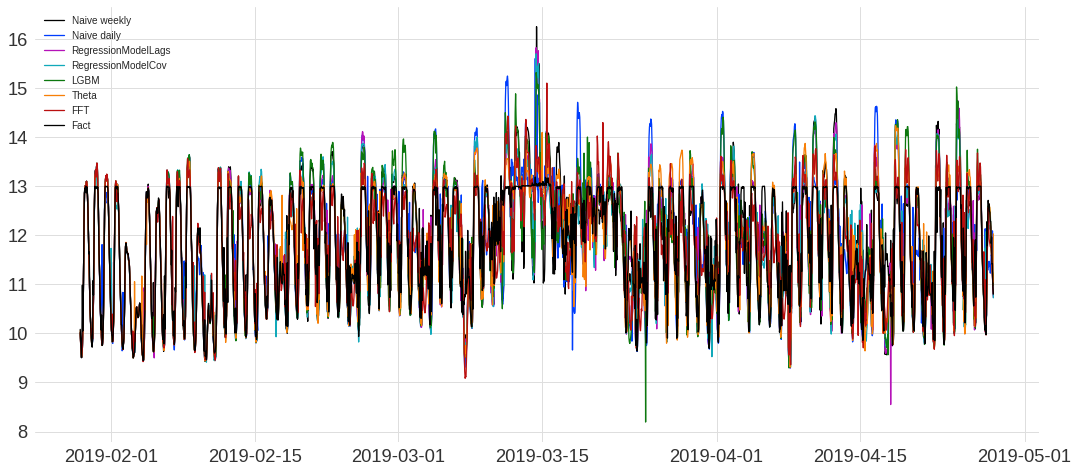

In [187]:
for col in range(len(sol)):
    plt.plot(sol[col].dropna()+data.y, label=sol[col].name)

#plt.plot(tmp.y.loc['2019-03-02':'2019-04-01'], label='Fact', lw=3)
plt.legend()

## Evaluation returns outputs of cost function for each of the models:

model cost_evaluation error_evaluation
0         Naive weekly    14397.497485         0.458085
1          Naive daily    16326.347752         0.747673
2  RegressionModelLags    15201.819622         0.386385
3   RegressionModelCov    13860.562612         0.560348
4                 LGBM    18176.134946         0.554977
5                Theta    17160.149714          0.30466
6                  FFT    11893.140161         0.778028
7                 Fact     2619.939465              0.0

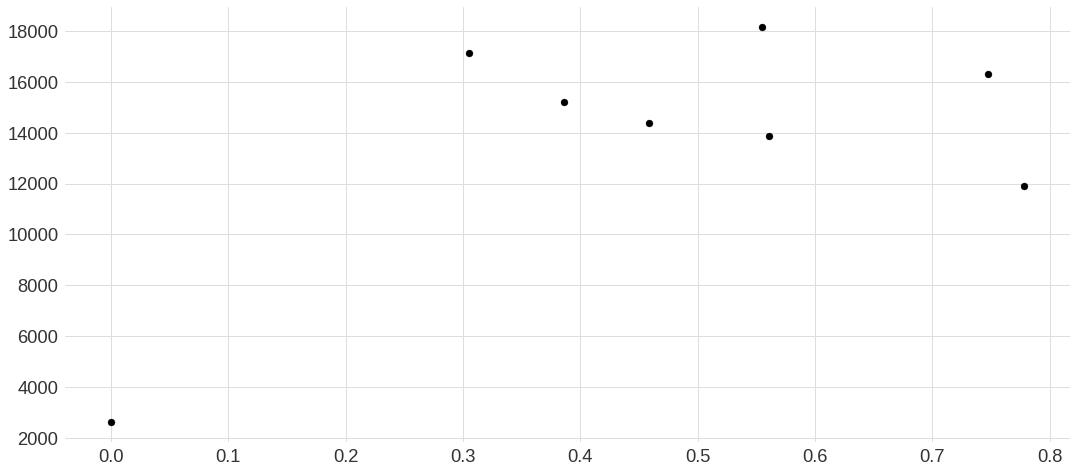

In [190]:
EVALUATE = True
results = odm.evaluate()
#plt.scatter(results[0],results[1])

plt.scatter(results['error_evaluation'],results['cost_evaluation'])

results

In [191]:
alt.Chart(results).mark_circle(size=500).encode(
    x='error_evaluation:Q',
    y=alt.Y('cost_evaluation:Q'),
    color=alt.Color('model:N'),
    tooltip = ['model:N','error_evaluation:Q','cost_evaluation:Q']
).properties(width=600, height=600)


alt.Chart(...)

In [197]:
runtime_df.index

Index(['Naive weekly', 'Naive daily', 'RegressionModelLags',
       'RegressionModelCov', 'LGBM', 'Theta', 'FFT'],
      dtype='object')

In [202]:
results = results.join(runtime_df, how='left', on='model')

In [204]:
results.to_csv('results/VOF_7m_90d.csv')